# Optimizing VGG-16

In [1]:
!pip install scikeras

In [2]:
!pip install tensorflow==2.14.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 1.1 MB/s eta 0:00:0000:0100:07m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 1.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 1.1 MB/s eta 0:00:00a 0:00:01m
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.2.0
    Uninstalling google-auth-oauthlib-1.2.0:
      Successfully uninstalled google-auth-oauthlib-1.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard

In [3]:
import os
import math
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import applications, Model
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from scikeras.wrappers import KerasClassifier
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
import sklearn
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV, KFold
from PIL import Image

warnings.simplefilter('ignore')

2024-03-21 07:07:18.866191: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 07:07:18.866244: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 07:07:18.866283: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
train_data_dir = '/kaggle/input/landmark-identification/FinalData/Training_Data'
validation_data_dir = '/kaggle/input/landmark-identification/FinalData/Validation_Data'
test_data_dir= '/kaggle/input/landmark-identification/FinalData/Test_Data'

training_features_file = 'Features/training_features_VGG16.npy'
validation_features_file = 'Features/validation_features_VGG16.npy'
top_weights_file = 'Weights/weights_VGG16.h5'
model_file = 'Models/model_vgg16.h5'

train_labels_file = '/kaggle/input/landmark-identification/Labels/training_labels.npy'
validation_labels_file = '/kaggle/input/landmark-identification/Labels/validation_labels.npy'
test_labels_file = '/kaggle/input/landmark-identification/Labels/test_labels.npy'

img_width, img_height = 224, 224
num_classes = 10

In [5]:
train_labels = np.load(open(train_labels_file, 'rb'))
validation_labels = np.load(open(validation_labels_file, 'rb'))
test_labels = np.load(open(test_labels_file, 'rb'))

In [6]:
print('Training Data : ' + str(len(train_labels)) + ' Images')
print('Validation Data : ' + str(len(validation_labels)) + ' Images')
print('Test Data : ' + str(len(test_labels)) + ' Images')

Training Data : 61 Images
Validation Data : 10 Images
Test Data : 11 Images


## Converting images to feature vectors using weights from ImageNet

In [7]:
def images_to_feature_vectors(model, directory, batch_size, steps):
    
    datagen = tf.keras.preprocessing.image.ImageDataGenerator()
    
    generator = datagen.flow_from_directory(
        directory,
        target_size = (img_width, img_height),
        batch_size = batch_size,
        class_mode = None,
        shuffle = False) # Keep the data in the same order
    
    features = model.predict(generator, steps, verbose=1) 
    
    return features

In [8]:
training_batch_size = 1 # batch size for feature pre-training
validation_batch_size = 1 # batch size for feature pre-training
# Batch size has to be a multiple of the number of images  to keep our vectors consistents

base_model = applications.VGG16(include_top=False, weights='imagenet', input_shape=(img_width,img_height,3)) #VGG16 trained on imagenet
training_features = images_to_feature_vectors(base_model, train_data_dir, training_batch_size, len(train_labels) // training_batch_size)
validation_features = images_to_feature_vectors(base_model, validation_data_dir, validation_batch_size, len(validation_labels) // validation_batch_size)

58889256/58889256 [==============================] - 0s 0us/step
Found 61 images belonging to 10 classes.
61/61 [==============================] - 9s 152ms/step
Found 10 images belonging to 5 classes.
10/10 [==============================] - 2s 152ms/step


In [9]:
os.makedirs(os.path.dirname(training_features_file), exist_ok=True)
os.makedirs(os.path.dirname(validation_features_file), exist_ok=True)
with open(training_features_file, 'wb') as file:
        np.save(file, training_features, allow_pickle = False)
with open(validation_features_file, 'wb') as file:
        np.save(file, validation_features, allow_pickle = False)

## Randomized Search CV training

In [10]:
train_data = np.load(open(training_features_file, 'rb'))
train_labels_onehot = to_categorical(train_labels, num_classes)            #One Hot Encoder

In [11]:
def create_model(lr, nn1, nn2, nn3):
    opt = keras.optimizers.Adam(learning_rate=lr)           
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(nn1, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(nn2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(nn3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, lr=1e-2, nn1=4096, nn2=2048, nn3=1000, epochs=16, verbose=1)

# Learning rate values
lr = [1e-2, 1e-3, 1e-4]
# Number of neurons per layer
nn1 = [4096,2048,1024]
nn2 = [2048,1024,512]
nn3 = [1000,500,200]
# Batch size
batch_size = [2048,1024,512]
# Parameters grid
param_grid = dict(
                    lr = lr,
                    nn1 = nn1,
                    nn2 = nn2,
                    nn3 = nn3,
                    batch_size = batch_size
                 )

grid = RandomizedSearchCV(estimator = model,
                          cv = KFold(2),
                          param_distributions = param_grid, 
                          verbose = 2,
                          n_iter = 10,
                          n_jobs = 1)

In [12]:
model.get_params().keys()

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'lr', 'nn1', 'nn2', 'nn3', 'class_weight'])

In [13]:
grid_result = grid.fit(train_data, train_labels_onehot)
grid_result

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Epoch 1/16
1/1 [==============================] - 2s 2s/step - loss: 3.1093 - accuracy: 0.1000
Epoch 2/16
1/1 [==============================] - 0s 497ms/step - loss: 0.3274 - accuracy: 0.9333
Epoch 3/16
1/1 [==============================] - 1s 510ms/step - loss: 0.0578 - accuracy: 1.0000
Epoch 4/16
1/1 [==============================] - 1s 520ms/step - loss: 0.0046 - accuracy: 1.0000
Epoch 5/16
1/1 [==============================] - 1s 506ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 6/16
1/1 [==============================] - 1s 514ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 7/16
1/1 [==============================] - 1s 565ms/step - loss: 9.8701e-04 - accuracy: 1.0000
Epoch 8/16
1/1 [==============================] - 1s 520ms/step - loss: 7.4457e-04 - accuracy: 1.0000
Epoch 9/16
1/1 [==============================] - 1s 524ms/step - loss: 5.7743e-04 - accuracy: 1.0000
Epoch 10/16
1/1 [==============================]

RandomizedSearchCV(cv=KFold(n_splits=2, random_state=None, shuffle=False),
                   estimator=KerasClassifier(build_fn=<function create_model at 0x786c5c063250>, epochs=16, lr=0.01, nn1=4096, nn2=2048, nn3=1000),
                   n_jobs=1,
                   param_distributions={'batch_size': [2048, 1024, 512],
                                        'lr': [0.01, 0.001, 0.0001],
                                        'nn1': [4096, 2048, 1024],
                                        'nn2': [2048, 1024, 512],
                                        'nn3': [1000, 500, 200]},
                   verbose=2)

In [15]:
cv_results_df = pd.DataFrame(grid_result.cv_results_)
cv_results_df.to_csv('randomizedsearchcv_VGG16.csv')

In [16]:
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_nn3,param_nn2,param_nn1,param_lr,param_batch_size,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,12.356388,0.139453,0.189797,0.002406,1000,1024,2048,0.001,1024,"{'nn3': 1000, 'nn2': 1024, 'nn1': 2048, 'lr': ...",0.032258,0.466667,0.249462,0.217204,4
1,6.485989,0.447379,0.156679,0.005672,200,1024,1024,0.01,2048,"{'nn3': 200, 'nn2': 1024, 'nn1': 1024, 'lr': 0...",0.096774,0.133333,0.115054,0.018280,8
2,21.109951,1.837079,0.206403,0.000053,1000,2048,4096,0.0001,2048,"{'nn3': 1000, 'nn2': 2048, 'nn1': 4096, 'lr': ...",0.258065,0.400000,0.329032,0.070968,2
3,20.826075,2.312408,0.199630,0.000932,500,1024,4096,0.01,2048,"{'nn3': 500, 'nn2': 1024, 'nn1': 4096, 'lr': 0...",0.129032,0.000000,0.064516,0.064516,9
4,20.569828,2.293582,0.202729,0.000273,200,1024,4096,0.001,2048,"{'nn3': 200, 'nn2': 1024, 'nn1': 4096, 'lr': 0...",0.064516,0.433333,0.248925,0.184409,5
5,11.156409,1.042136,0.168124,0.000780,500,1024,2048,0.0001,2048,"{'nn3': 500, 'nn2': 1024, 'nn1': 2048, 'lr': 0...",0.129032,0.533333,0.331183,0.202151,1
6,6.534051,0.404330,0.160810,0.001197,500,1024,1024,0.001,512,"{'nn3': 500, 'nn2': 1024, 'nn1': 1024, 'lr': 0...",0.000000,0.400000,0.200000,0.200000,6
7,11.359412,0.948856,0.373711,0.200193,200,2048,2048,0.001,1024,"{'nn3': 200, 'nn2': 2048, 'nn1': 2048, 'lr': 0...",0.000000,0.400000,0.200000,0.200000,6
8,9.886684,0.067316,0.186466,0.015519,200,512,2048,0.001,2048,"{'nn3': 200, 'nn2': 512, 'nn1': 2048, 'lr': 0....",0.161290,0.433333,0.297312,0.136022,3
9,12.309821,0.054446,0.174214,0.002379,1000,512,2048,0.01,2048,"{'nn3': 1000, 'nn2': 512, 'nn1': 2048, 'lr': 0...",0.000000,0.066667,0.033333,0.033333,10


In [17]:
grid_result.best_params_

{'nn3': 500, 'nn2': 1024, 'nn1': 2048, 'lr': 0.0001, 'batch_size': 2048}

In [18]:
# Parameters after RandomizedSearchCV
lr = 0.0001
nn1 = 2048
nn2 = 1024
nn3 = 500
batch_size = 2048

## Training top part of the model using regularization

In [19]:
# Regularization Parameters
dropout = 0.5
l1 = 0.0001
l2 = 0.0001

In [20]:
def model():
    opt = keras.optimizers.Adam(learning_rate=lr)
    reg = keras.regularizers.l1_l2(l1=l1, l2=l2)
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(nn1, activation='relu', kernel_regularizer=reg))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Dense(nn2, activation='relu', kernel_regularizer=reg))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Dense(nn3, activation='relu', kernel_regularizer=reg))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [21]:
validation_data = np.load(open(validation_features_file, 'rb'))
validation_labels_onehot = to_categorical(validation_labels, num_classes)  #One Hot Encoder

In [22]:
top = model()

In [23]:
top.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_21 (Flatten)        (None, 25088)             0         
                                                                 
 dense_84 (Dense)            (None, 2048)              51382272  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization_63 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense_85 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                     

In [24]:
history = top.fit(train_data, train_labels_onehot,
              epochs=32,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels_onehot))

Epoch 1/32
1/1 [==============================] - 5s 5s/step - loss: 47.9220 - accuracy: 0.1639 - val_loss: 52.8738 - val_accuracy: 0.2000
Epoch 2/32
1/1 [==============================] - 1s 1s/step - loss: 47.7584 - accuracy: 0.1311 - val_loss: 49.9642 - val_accuracy: 0.2000
Epoch 3/32
1/1 [==============================] - 1s 1s/step - loss: 46.8936 - accuracy: 0.2295 - val_loss: 48.1545 - val_accuracy: 0.2000
Epoch 4/32
1/1 [==============================] - 1s 1s/step - loss: 46.7699 - accuracy: 0.2623 - val_loss: 47.0338 - val_accuracy: 0.2000
Epoch 5/32
1/1 [==============================] - 1s 1s/step - loss: 46.2640 - accuracy: 0.2787 - val_loss: 46.2423 - val_accuracy: 0.4000
Epoch 6/32
1/1 [==============================] - 1s 1s/step - loss: 45.9093 - accuracy: 0.3443 - val_loss: 45.7004 - val_accuracy: 0.6000
Epoch 7/32
1/1 [==============================] - 1s 1s/step - loss: 45.6973 - accuracy: 0.4098 - val_loss: 45.3289 - val_accuracy: 0.6000
Epoch 8/32
1/1 [===========

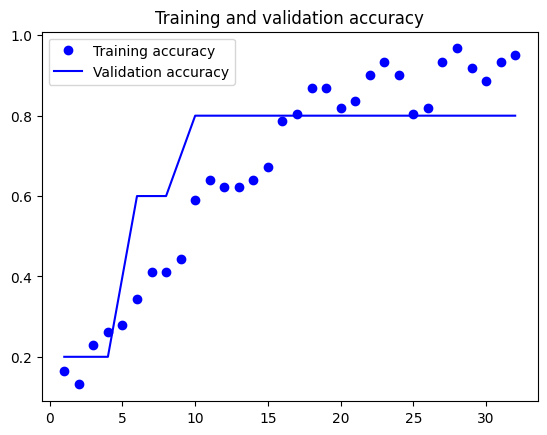

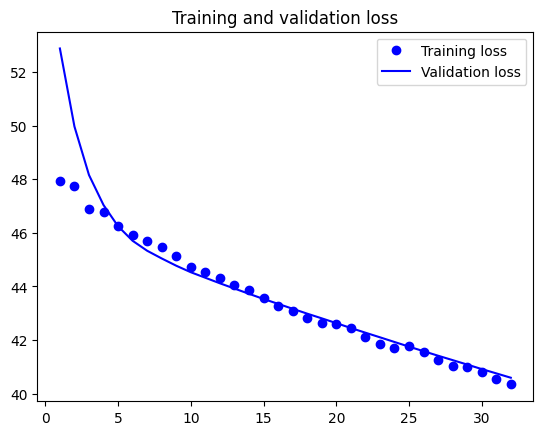

In [25]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [26]:
os.makedirs(os.path.dirname(top_weights_file), exist_ok=True)
top.save_weights(top_weights_file)

## Defining and testing the complete model

In [27]:
def complete_model():
    opt = keras.optimizers.Adam(learning_rate=lr)
    reg = keras.regularizers.l1_l2(l1=l1, l2=l2)
    base = applications.VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3)) #VGG16 trained on imagenet
    top = Sequential()
    top.add(Flatten(input_shape=train_data.shape[1:]))
    top.add(Dense(nn1, activation='relu', kernel_regularizer=reg))
    top.add(BatchNormalization())
    top.add(Dense(nn2, activation='relu', kernel_regularizer=reg))
    top.add(BatchNormalization())
    top.add(Dense(nn3, activation='relu', kernel_regularizer=reg))
    top.add(BatchNormalization())            
    top.add(Dense(num_classes, activation='softmax'))
    top.load_weights(top_weights_file)
    top.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'],)
    model = Model(base.input, top(base.output))
    for layer in model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'],)
    return model

In [28]:
model = complete_model()
datagen = tf.keras.preprocessing.image.ImageDataGenerator()
print("Model Summary:")
model.summary()

Model Summary:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 12

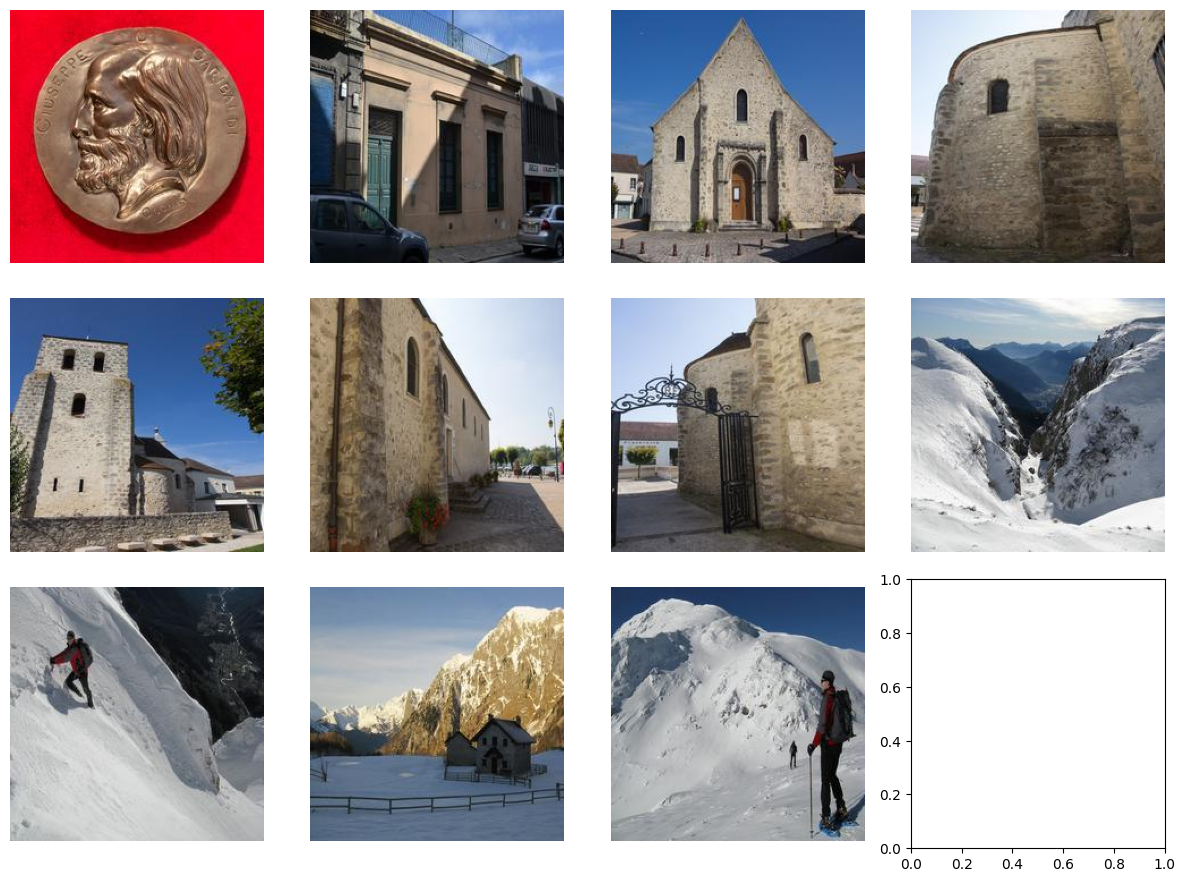

In [50]:
# Displaying test images
def display_images_from_dir(directory):
    # Get list of all files within subdirectories of the directory
    image_files = []
    i = 0
    while i < num_classes:
        if os.path.exists(directory + '/'+ str(i)):
            for root, dirs, files in os.walk(directory +'/'+ str(i)):
                for file in files:
                    image_files.append(os.path.join(directory, str(i), file))
        i += 1
    
    # Create a figure to display images
    num_images = len(image_files)
    num_cols = 4
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 3*num_rows))

    # Iterate through image files and display each one
    for i, image_file in enumerate(image_files):
        # Load the image
        image_path = os.path.join(directory, image_file)
        image = Image.open(image_path)
        
        # Determine subplot position
        row = i // num_cols
        col = i % num_cols
        
        # Display the image
        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.imshow(image)
        ax.axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

display_images_from_dir(test_data_dir)

In [29]:
generator = datagen.flow_from_directory(
            test_data_dir,
            target_size=(img_width, img_height),
            batch_size=len(test_labels),
            class_mode=None,
            shuffle=False)
test_predictions = model.predict(generator, 1, verbose=1)

Found 11 images belonging to 3 classes.
1/1 [==============================] - 2s 2s/step


In [30]:
test_predictions = np.asarray(list(map(str,np.argmax(test_predictions,axis=1)))).reshape(-1,1)
test_predictions

array([['6'],
       ['6'],
       ['7'],
       ['7'],
       ['7'],
       ['7'],
       ['8'],
       ['8'],
       ['9'],
       ['7'],
       ['9']], dtype='<U1')

In [32]:
test_labels = np.asarray(test_labels).reshape(-1,1)

In [33]:
test_labels

array([['6'],
       ['6'],
       ['7'],
       ['7'],
       ['7'],
       ['7'],
       ['7'],
       ['9'],
       ['9'],
       ['9'],
       ['9']], dtype='<U1')

In [34]:
test_predictions.shape

(11, 1)

In [35]:
test_labels.shape

(11, 1)

In [40]:
# Create an instance of the Accuracy metric
accuracy_metric = tf.keras.metrics.Accuracy()

# Update the state of the accuracy metric with true labels and predictions
test_labels = [float(pred) for pred in test_labels]
test_predictions = [float(pred) for pred in test_predictions]
accuracy_metric.update_state(test_labels, test_predictions)

# Get the test accuracy result
accuracy_result = accuracy_metric.result()
print("Testing Accuracy:", accuracy_result.numpy())

Testing Accuracy: 0.72727275


In [37]:
os.makedirs(os.path.dirname(model_file), exist_ok=True)
model.save(model_file)

In [38]:
!zip -r file.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/Models/ (stored 0%)
  adding: kaggle/working/Models/model_vgg16.h5 (deflated 7%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/Features/ (stored 0%)
  adding: kaggle/working/Features/training_features_VGG16.npy (deflated 86%)
  adding: kaggle/working/Features/validation_features_VGG16.npy (deflated 86%)
  adding: kaggle/working/Weights/ (stored 0%)
  adding: kaggle/working/Weights/weights_VGG16.h5 (deflated 7%)
  adding: kaggle/working/randomizedsearchcv_VGG16.csv (deflated 65%)


In [39]:
from IPython.display import FileLink
FileLink(r'file.zip')

/kaggle/working/file.zip